# Evaluating Simpler Models on collected data

Because a Neural Net seems like overkill.

In [1]:
import os
import time
from datetime import date

from collections import defaultdict
from tempfile import NamedTemporaryFile
from typing import List, Tuple

import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from matplotlib.ticker import AutoMinorLocator

from optpresso.data.df import (
    dataframe_from_csv,
    convert_datetime_to_epoch_time,
    find_columns_to_drop,
    prepare_df_for_modeling,
)

from IPython.display import display

# On linux HistGradientBoostingRegressor can freak out with too many threads
# https://github.com/scikit-learn/scikit-learn/issues/16016
os.environ["OMP_NUM_THREADS"] = "4"

from scipy.stats import median_abs_deviation

from sklearn.ensemble import HistGradientBoostingRegressor, GradientBoostingRegressor
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, MultiLabelBinarizer
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [2]:
def convert_epoch_to_days(epoch_date):
    return epoch_date // (3600 * 24)

In [3]:
# Disable GPU, fast enough without
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
DATA_DOWNLOAD_URL = "https://docs.google.com/spreadsheets/d/1dDfuIq74pjELNtfb_0sdiNnG3qFKrfqC2sax7ewrWYg/export?format=csv"

In [4]:
def prepare_dataframe(df):
    df = df.copy()
    for char in [" ", "(", ")", "%", "/", "\\", '"']:
        df.columns = df.columns.str.strip().str.lower().str.replace(char, "", regex=False)
    invalid_indices = df[df["time"].isna()].index
    df.drop(invalid_indices, inplace=True)
    df = df[pd.to_numeric(df["grindersetting"], errors="coerce").notnull()]
    roast_date = pd.to_datetime(
        df.roastdate, infer_datetime_format=True, utc=True
    ).map(convert_datetime_to_epoch_time)
    df["date"] = pd.to_datetime(df.date, infer_datetime_format=True, utc=True).map(
        convert_datetime_to_epoch_time
    )
    df["timesinceroast"] = convert_epoch_to_days(df["date"] - roast_date)
    df["grindersetting"] = df["grindersetting"].astype(np.float64)
    df[["roaster", "coffee"]] = df["coffee"].str.lower().str.split("-", 1, expand=True)
    df["coffee"] = df["coffee"].astype(str).replace("None", "").str.strip()
    df["coffee_words"] = df["coffee"].str.split(" ")
    df["machineprofile"] = (
        df["machineprofile"].fillna("").replace("", "default").str.lower()
    )
    df["basket"] = (
        df["basket"].fillna("").replace("", "default").str.lower()
    )
    df["roaster"] = df["roaster"].astype(str).replace("None", "").str.strip()
    df["brewratio"] = df["output"] / df["coffeegrams"]
    df["roastdate"] = df["roastdate"].fillna("").str.strip()
    df["filter"] = df["filter"].fillna("").str.strip()
    return df


In [5]:
df = dataframe_from_csv(DATA_DOWNLOAD_URL)
df = prepare_dataframe(df)
rng = np.random.default_rng(814)

encoded_cols = ("grinder", "coffee", "roaster", "machine", "machineprofile", "coffee_words", "roastdate", "basket", "filter")

encs = {}
for col in encoded_cols:
    if col not in df:
        print("No such column to encode", col)
        continue
    if not isinstance(df[col], object) and len(df[col].unique()) <= 1:
        print(f"Column {col} has 1 or fewer values, not encoding")
        continue
    print("Encoding", col)
    if isinstance(df[col].values[0], str):
        encoder = OrdinalEncoder(
            handle_unknown="use_encoded_value", unknown_value=len(df[col].unique())
        )
        encoder.fit(df[col].values.reshape(-1, 1))
    elif isinstance(df[col].values[0], list):
        encoder = MultiLabelBinarizer()
        encoder.fit(df[col].values)
    else:
        print(df[col])
        raise TypeError("Unknown type for encoding", col, type(df[col].values[0]))
    encs[col] = encoder

# Drop fields that aren't going to be encoded or are a pandas type
for field in df.columns:
    if field in encs:
        continue
    if df[field].dtype == object:
        print("Dropping", field)
        df = df.drop([field], axis=1)
        
for col in find_columns_to_drop(df):
    if col in encoded_cols:
        continue
    print("Dropping", col)
    df = df.drop(col, axis=1)

for col in ["arbitraryrating1-10"]:
    if col in df.columns:
        print("Dropping", col)
        df = df.drop(col, axis=1)
# Shuffle, in case ordering matters
df = df.sample(frac=1, random_state=rng).reset_index(drop=True)

Encoding grinder
Encoding coffee
Encoding roaster
Encoding machine
Encoding machineprofile
Encoding coffee_words
Encoding roastdate
Encoding basket
Encoding filter
Dropping details
Dropping timeprediction
Dropping tdsatagounfiltered
Dropping tdstempc
Dropping arbitraryrating1-10


## Use distribution of grams of input coffee to enhance data

Initially values were just the grams weighed before grinding. After getting a more precise scale, data has been collected after grinding/prep, want to see if using that data can enhance the training.

In [6]:
def resample_field(
    frame, field: str, groupby: List[str], mean=0.0, std=1.0, samples: int = 3, seed: int = 814
):
    to_sample = []
    rng = np.random.default_rng(seed)
    # Duplicate a bunch of samples
    for name, subdf in frame.groupby(groupby):
        to_return = pd.concat([subdf] * samples)
        noise = rng.normal(mean, std, size=len(to_return))
        to_return[field] = (to_return[field].values + noise).tolist()
        to_sample.append(to_return)
    new_data = pd.concat(to_sample).sample(frac=1, random_state=seed).reset_index(drop=True)
    if field in ["coffeegrams", "output"]:
        new_data.brewratio = new_data.output / new_data.coffeegrams
    return new_data

In [7]:
def construct_regressor(estimators: int = 125):
    return HistGradientBoostingRegressor(
#         loss='poisson',
        max_iter=estimators, random_state=814
    )

## Evaluate using GradientBoosting to make predictions

It is feasible to build a personalized GradientBoost model, and this is to do a basic proof of concept to see if it isn't totally worthless.

In [8]:
def get_min_difference(df, field):
    diff = np.diff(np.sort(np.array(df[field].unique())))
    min_difference = np.round(np.min(diff[diff > 0]), 3)
    return min_difference

def plot_grinder_predictions(grinder: str, prediction_field: str, y, y_pred):
    fig, (ax, ax2) = plt.subplots(ncols=2, dpi=150, figsize=(9, 4.5))
    fig.suptitle(f"{grinder}\n{prediction_field.title()}")
    grinder_df = df[df.grinder == grinder]
    min_grinder_difference = get_min_difference(grinder_df, prediction_field)
    ax.scatter(
        y,
        y_pred,
        alpha=0.5,
    )
    lowest_point = min(np.min(y), np.min(y_pred)) - min_grinder_difference
    max_point = max(np.max(y), np.max(y_pred)) + min_grinder_difference
    ax.set_title("Predictions")
    
    ax.set_xlabel("Experimental")
    ax.set_ylabel("Prediction")
    min_fit_point = np.array([lowest_point] * 2)
    max_fit_point = np.array([max_point] * 2)
    ax.set_xlim(min_fit_point[0], max_fit_point[1])
    ax.axline(min_fit_point, slope=1, color="g", linestyle="--", label="fit")
    
    for factor in [1.0, 2.0]:
        ax.fill_between(
            [min_fit_point[0], max_fit_point[0]],
            [min_fit_point[1] - min_grinder_difference * factor, max_fit_point[1] - min_grinder_difference * factor],
            [min_fit_point[1] + min_grinder_difference * factor, max_fit_point[1] + min_grinder_difference * factor],
            color="gray",
            label="fit",
            alpha=0.25
        )
    ax.annotate(
        "RMSE = {:.2f}".format(np.sqrt(mean_squared_error(y, y_pred))),
        (1.03, 0.01),
        xycoords="axes fraction",
    )
    ax.annotate(
        "MUE = {:.2f}".format(mean_absolute_error(y, y_pred)),
        (1.03, 0.07),
        xycoords="axes fraction",
    )
    ax.annotate(
        "MAD = {:.2f}".format(median_abs_deviation(y - y_pred)),
        (1.03, 0.12),
        xycoords="axes fraction",
    )
    

    ax2.hist(y_pred - y, bins=30, density=True)
    ax2.set_title(f"Residuals")
    ax2.set_xlabel("Error")
    ax2.set_ylabel("Density")
    fig.tight_layout()
    return fig

Prediction grindersetting
With Dropped columns: ('date', 'brewratio')


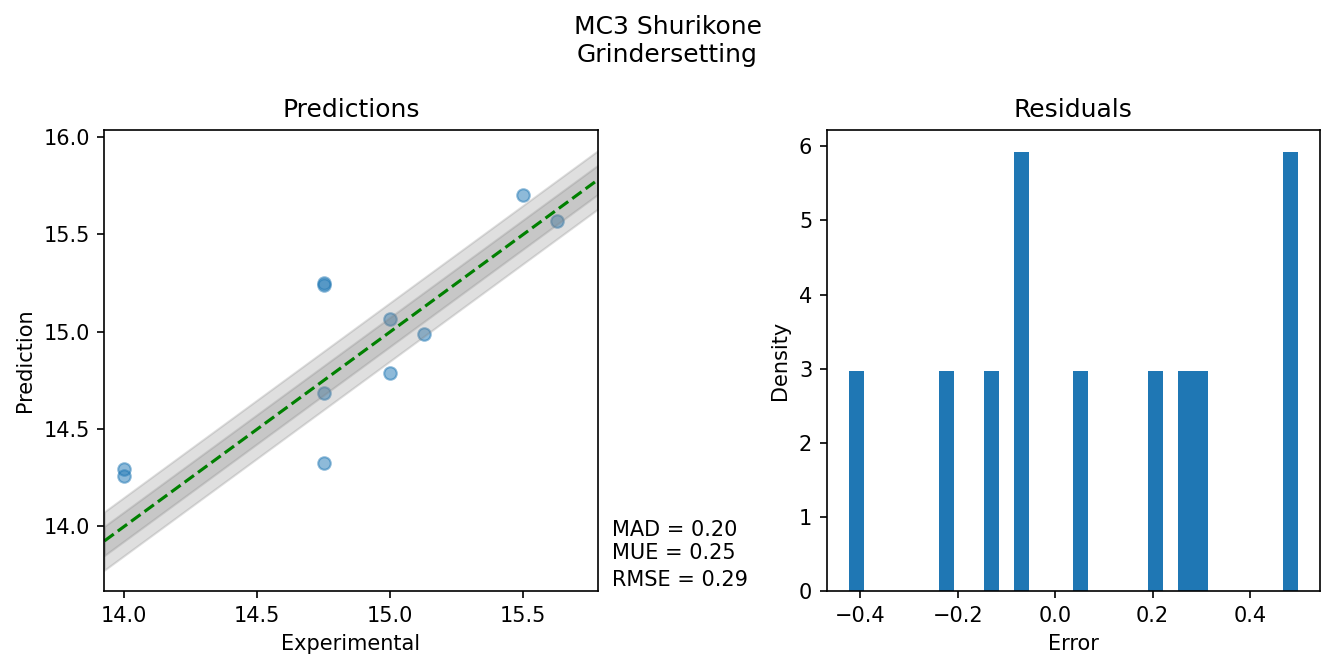

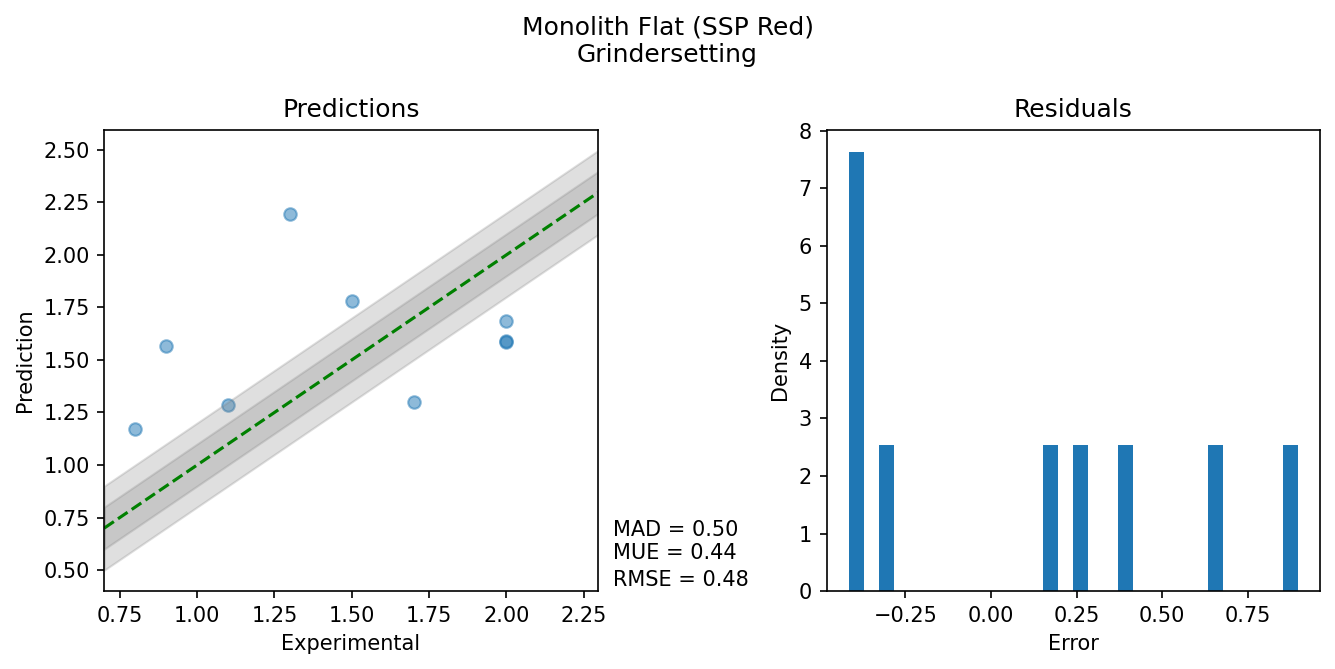

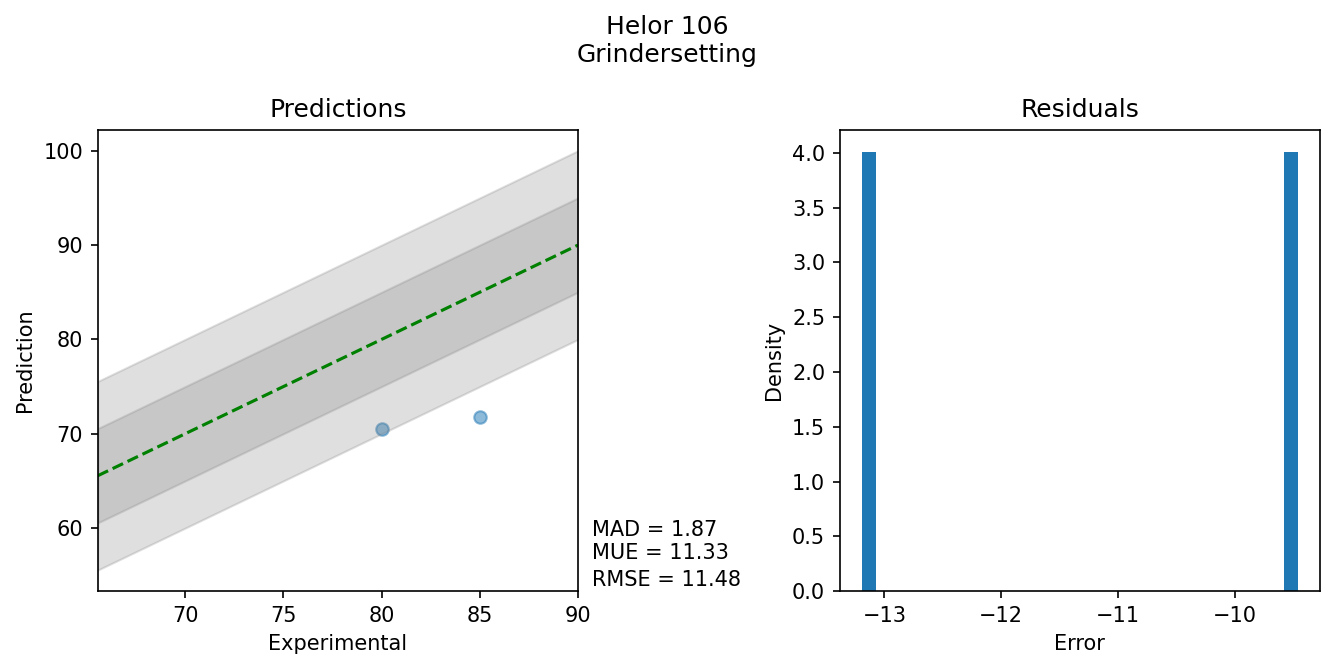

Prediction time
With Dropped columns: ('date', 'brewratio')


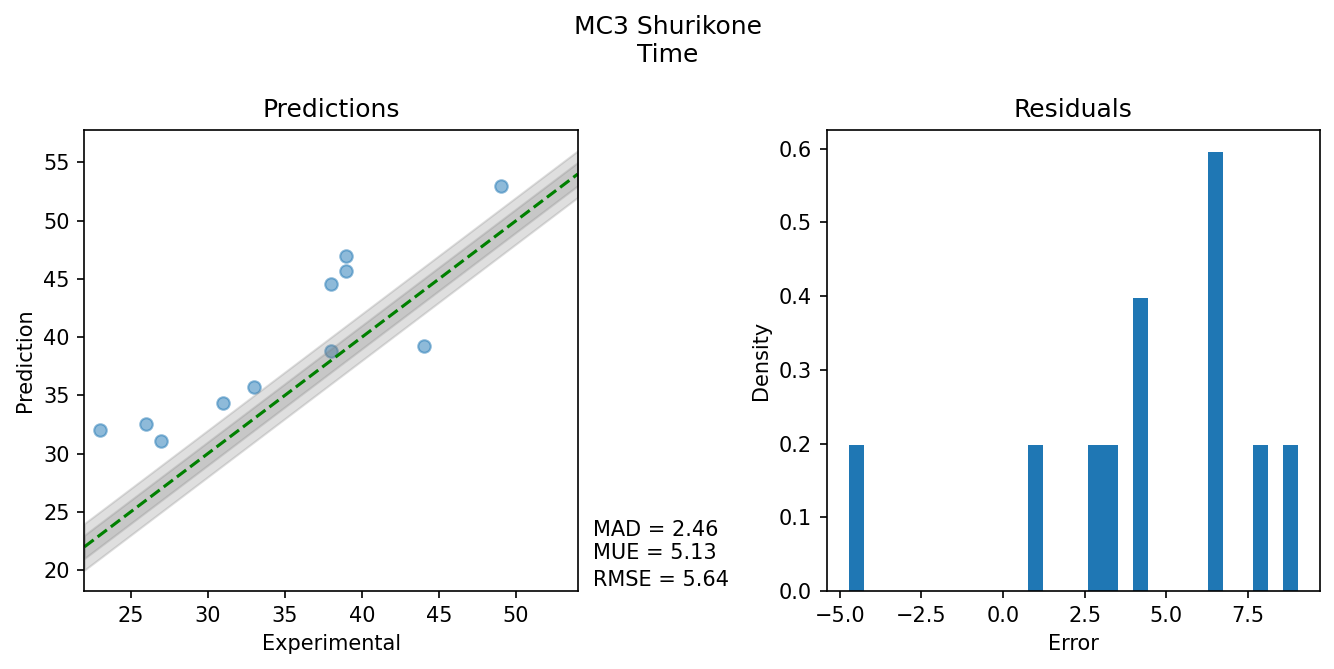

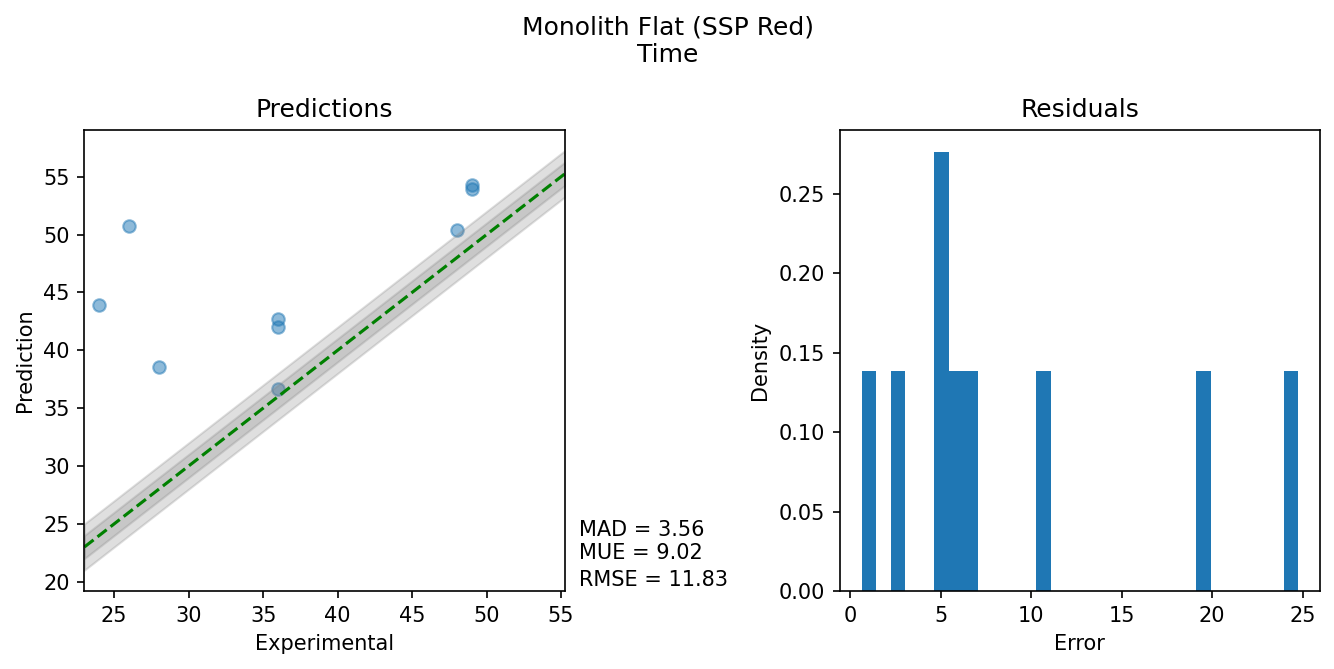

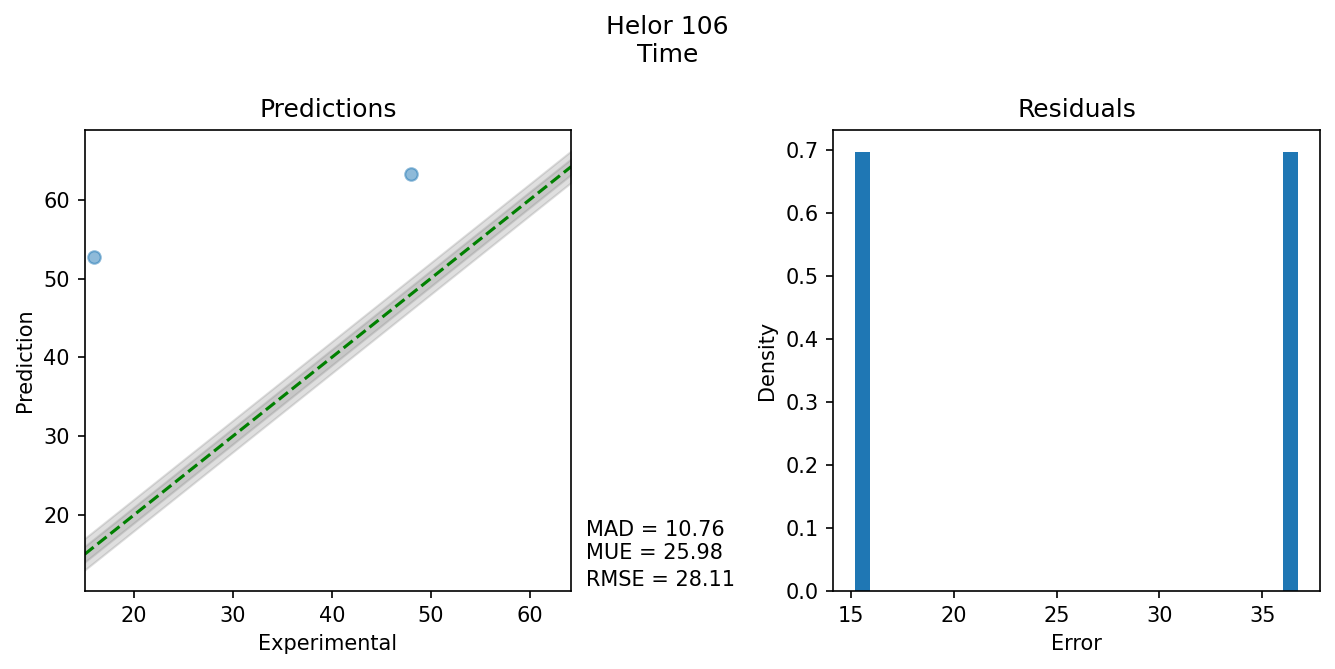

In [9]:
# Samples values for the training set
enhance_sample = True

estimators = 600
num_days = 7
days_in_seconds = 24 * 60 * 60 * num_days
data = df.copy()
latest_date = data.date.max()
# Training data is everything num_days before the most recent pull
train = data[data.date < latest_date - days_in_seconds]
test = data.drop(train.index)

if enhance_sample:
    sampled_coffee = resample_field(train, "coffeegrams", ["grinder", "coffee"], std=0.05, samples=2)
#     sampled_output = resample_field(
#         train, "output", ["machine", "machineprofile"], samples=1
#     )
    train = pd.concat([train, sampled_coffee])
for prediction_field in ["grindersetting", "time"]:
    print("Prediction", prediction_field)
    for dropped in [("date", "brewratio")]:
        print("With Dropped columns:", dropped)
        x, y = prepare_df_for_modeling(
            train, prediction_field, drop_cols=dropped, encoders=encs
        )
        regr = construct_regressor(estimators=estimators)
        regr.fit(x, y)
        for grinder in test.grinder.unique():
            grinder_test = test[test.grinder == grinder]
            x_test, y_test = prepare_df_for_modeling(
                grinder_test, prediction_field, drop_cols=dropped, encoders=encs
            )
            yfit = regr.predict(x_test)
            plot_grinder_predictions(grinder, prediction_field, y_test, yfit)
            plt.show()

## Trying it out on new data

What happens if we throw 'novel' coffee at it, how well will it predict it across grinders?

In [10]:
def check_value_exists(field, ref_df, df):
    ref_val = ref_df[field].values[0]
    if ref_val not in df[field].values:
        print(f"No matching {field} '{ref_val}' found in dataframe")
        print("-----")

def percent_diff(x, y):
    return np.abs(x - y) / x

## Train Model

Select the number of estimators and whether to try and generate more samples.

In [11]:
enhance_sample = True
estimators = 600
dropped = ("date", "brewratio")

training = df
if enhance_sample:
    sampled_coffee = resample_field(training, "coffeegrams", ["grinder", "coffee"], std=0.05, samples=3)
#     sampled_output = resample_field(
#         training, "output", ["machine", "machineprofile", "grinder", "coffee"], samples=1
#     )
    training = pd.concat([training, sampled_coffee])

x, y = prepare_df_for_modeling(
    training, "grindersetting", drop_cols=dropped, encoders=encs
)
regr = construct_regressor(estimators)
regr.fit(x, y)
print(f"Trained model with {len(y)} data points")

Trained model with 14236 data points


## Run Model Prospectively

Modify the data dictionary to run the trained model.

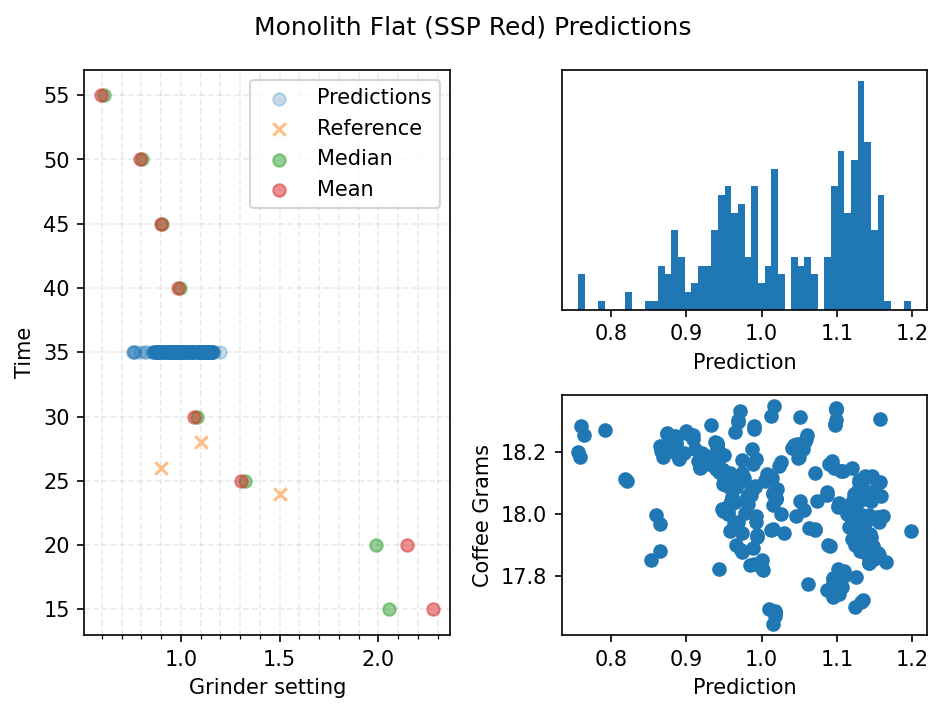

In [12]:
data = {
    "coffee": "Luna - IHCafe90 Olga Benitez Marcala Honduras Espresso",
    "coffeegrams": 18.0,
    "roastdate": "03/06/23",
    "time": 35,
    "output": 36.0,
    "machine": "Decent DE1PRO",
    "machineprofile": "",
    "grinder": "Monolith Flat (SSP Red)",  # Leave None to predict for all grinders,
    "basket": "Weber Unibasket",
    "filter": "",
}


data["date"] = date.today().strftime("%m/%d/%Y")
data["grindersetting"] = 0.5  # Meaningless value

data_df = pd.DataFrame.from_dict([data])
data_df = prepare_dataframe(data_df)

for field in ["roaster", "coffee", "machine", "machineprofile", "basket"]:
    check_value_exists(field, data_df, df)

profile_df = training[
    (training.machine == data_df.machine.values[0])
    & (training.machineprofile == data_df.machineprofile.values[0])
]

weight_values = np.array(df.coffeegrams.unique())
# If greater than 2% difference in weight, ignore
valid_weights_idxs = np.argwhere(percent_diff(data["coffeegrams"], weight_values) < 0.02).reshape(-1)
weight_values = weight_values[valid_weights_idxs]

max_profile_time = min(120, profile_df.time.max())
step_size = 5
min_profile_time = max(
    step_size, profile_df.time.min() - (profile_df.time.min() % step_size)
)
sample_times = list(
    range(int(min_profile_time), int(max_profile_time) + step_size, step_size)
)
prediction_time = data["time"]

test_df = data_df.copy()
        
# Look at the all the different coffeegrams that passed the threshold
for val in weight_values:
    median_output = df[df.coffeegrams == val].output.median()

    # If there is no median value or output is greater than 5% diff, ignore
    if np.isnan(median_output) or percent_diff(data["output"], median_output) > 0.05:
        continue
    weight_df = data_df.copy()
    weight_df["coffeegrams"] = [val]
    weight_df["output"] = [median_output]
    test_df = pd.concat([test_df, weight_df])

# Recompute brewratio
test_df["brewratio"] = (
    test_df.output / test_df.coffeegrams
)

for grinder in df.grinder.unique():
    if data["grinder"] is not None and data["grinder"].lower() != grinder.lower():
        continue
    test_grinder_df = test_df.copy()
    test_grinder_df = test_grinder_df.assign(grinder=[grinder] * len(test_grinder_df))
    grinder_df = df[
        df.grinder == grinder
    ]
    if len(grinder_df) == 0:
        print("No values for grinder", grinder)
        continue
    fig = plt.figure(dpi=150)
    fig.suptitle(f"{grinder} Predictions")
    plot1 = fig.add_subplot(222)
    plot2 = fig.add_subplot(224)
    plot3 = fig.add_subplot(121)
    plot1.set_xlabel("Prediction")
    plot1.set_yticks([])
    plot2.set_ylabel("Coffee Grams")
    plot2.set_xlabel("Prediction")

    times = []
    med = []
    mean = []
    if prediction_time not in sample_times:
        sample_times.append(prediction_time)
    
    for time in sample_times:
        test_grinder_df["time"] = [time] * len(test_grinder_df)
        
        x_set, _ = prepare_df_for_modeling(test_grinder_df, "grindersetting", drop_cols=dropped, encoders=encs)
        grams_idx = np.argwhere(x_set[-1] == test_grinder_df.coffeegrams.values[-1]).reshape(-1)
        pred_fit = regr.predict(x_set)

        if time == prediction_time:
            grams_x = x_set[:, grams_idx].reshape(-1)
            plot1.hist(pred_fit, bins=50, label="Predictions", density=True)
            plot2.scatter(pred_fit, grams_x, label="Predictions")
            if len(pred_fit):
                plot3.scatter(
                    pred_fit,
                    [time] * len(pred_fit),
                    label="Predictions",
                    marker="o",
                    alpha=0.25,
                )
        else:
            mean_pred = np.mean(pred_fit)
            med_pred = np.median(pred_fit)
            mean.append(mean_pred)
            med.append(med_pred)
            times.append(time)

    reference_vals = grinder_df[
        (grinder_df.coffee == test_df.coffee.values[0])
        & (grinder_df.roaster == test_df.roaster.values[0])
        & (grinder_df.roastdate == test_df.roastdate.values[0])
        & (grinder_df.machine.str.lower() == test_df.machine.str.lower().values[0])
        & (grinder_df.grinder == grinder)
        & (grinder_df.machineprofile.str.lower() == test_df.machineprofile.str.lower().values[0])
        & (grinder_df.basket.str.lower() == test_df.basket.str.lower().values[0])
        & (grinder_df["filter"].str.lower() == test_df["filter"].str.lower().values[0])
    ]
    if len(reference_vals):
        plot3.scatter(
            reference_vals.grindersetting,
            reference_vals.time,
            label="Reference",
            marker="x",
            alpha=0.5,
        )
    
    plot3.scatter(med, times, label="Median", alpha=0.5)
    plot3.scatter(mean, times, label="Mean", alpha=0.5)

    plot3.set_ylabel("Time")
    plot3.set_xlabel("Grinder setting")
    plot3.get_xaxis().set_minor_locator(AutoMinorLocator())
    plot3.legend()
    plot3.set_axisbelow(True)
    plot3.grid(linestyle="--", which="both", alpha=.25)
    fig.tight_layout()
    plt.show()